# **Tarea PCA**
## Arantza Gomez Haro Gamboa

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos**

In [3]:
df = pd.read_csv('hitters.csv')
df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'])
df = df[df['Salary'].notnull()]
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,False,True,True,False,False,True
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,True,False,False,True,True,False


In [4]:
target = 'Salary'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CWalks,PutOuts,Assists,Errors,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,375,632,43,10,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,263,880,82,14,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,354,200,11,3,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,33,805,40,4,False,True,True,False,False,True
5,594,169,4,74,51,35,11,4408,1133,19,...,194,282,421,25,True,False,False,True,True,False


### **Varianza explicada de los primeros 3 componentes**

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [6]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)
x_components = pd.DataFrame(X_pca,index=X.index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
x_components.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
1,-0.282823,-2.650655,-0.962828,-1.328333,-0.409792,1.391088,-0.117568,0.091295,-0.041000,-0.282530,...,0.481319,0.387567,0.067692,0.144861,-0.080354,0.038152,-0.019248,-4.420414e-16,4.817839e-16,-1.059368e-16
2,0.582642,2.791535,0.299486,-1.519606,-0.694956,1.902715,0.247697,1.183705,-0.046066,-0.399892,...,-0.403330,-0.019805,0.066259,0.160979,-0.044363,0.014832,-0.003393,3.986222e-16,2.905286e-17,3.314204e-16
3,3.263233,-1.801441,-1.663563,1.340556,-1.203074,-1.010101,-0.904411,-0.831769,0.059186,0.220367,...,-0.023744,-0.377727,0.230462,0.011952,0.218379,0.037825,-0.066506,-1.149809e-15,1.258940e-15,3.381524e-16
4,-2.703012,-0.481545,-1.718358,1.552541,-1.586995,1.558802,-0.208833,-0.212553,-0.131257,0.392416,...,-0.144997,0.028571,0.041744,0.053038,0.044534,0.010358,-0.013581,-1.506078e-16,3.707616e-16,1.161078e-16
5,1.166912,1.852599,0.199107,-1.821658,3.619792,0.454013,0.053134,-0.997806,0.253163,-0.614440,...,0.305880,-0.091051,0.044181,0.012328,0.050543,0.126037,-0.071038,-8.226232e-16,6.951867e-16,3.314204e-16


In [7]:
print(objeto_pca.explained_variance_ratio_[0])
print(objeto_pca.explained_variance_ratio_[1])
print(objeto_pca.explained_variance_ratio_[2])

0.33351942255568734
0.19832966775014926
0.15939870583571422


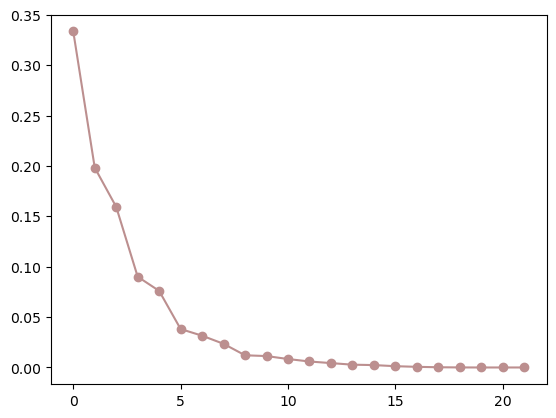

In [8]:
plt.plot(objeto_pca.explained_variance_ratio_, marker = "o", color = "rosybrown")

#### *Análisis:*

### **Primeras dos componentes y  KMeans**

#### *Gráfica de primeros dos componentes:*

Text(0, 0.5, 'Componente 2')

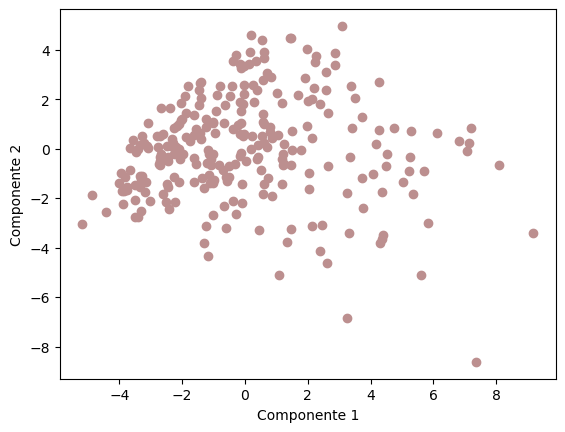

In [9]:
plt.scatter(x_components['PC1'], x_components['PC2'], color = "rosybrown")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

#### *Aplicación de KMeans:*

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters = 2))
])
pipeline.fit(X)

c:\Users\arant\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

Text(0, 0.5, 'Componente 2')

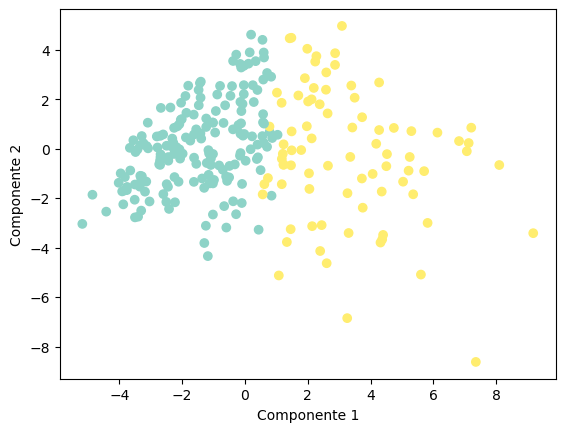

In [11]:
x_components['cluster'] = pipeline.predict(X) + 1
plt.scatter(x_components['PC1'], x_components['PC2'], c = x_components['cluster'], cmap="Set3")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")

#### *Análisis:*

### **Modelo Boosting**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
x_train_c = x_components.loc[X_train.index]
x_train_c = x_train_c.drop(columns=['cluster'])
x_test_c = x_components.loc[X_test.index]
x_test_c = x_test_c.drop(columns=['cluster'])


#### *XGBoost con todas las variables:*

In [28]:
model = XGBRegressor(
    n_estimators=10_000,
    max_depth=5,
    learning_rate=0.01,
    reg_lambda=0.5,
    subsample=0.5,
    colsample_bytree=0.8,
    eval_metric='rmse',
    early_stopping_rounds=1000,
)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=500)


[0]	validation_0-rmse:452.73529	validation_1-rmse:424.52683


[500]	validation_0-rmse:73.94117	validation_1-rmse:290.60819
[1000]	validation_0-rmse:29.17643	validation_1-rmse:287.56369
[1500]	validation_0-rmse:12.13555	validation_1-rmse:286.61839
[2000]	validation_0-rmse:5.00276	validation_1-rmse:286.29577
[2500]	validation_0-rmse:2.09884	validation_1-rmse:286.15875
[3000]	validation_0-rmse:0.91595	validation_1-rmse:286.10176
[3500]	validation_0-rmse:0.39832	validation_1-rmse:286.06754
[4000]	validation_0-rmse:0.17390	validation_1-rmse:286.05770
[4500]	validation_0-rmse:0.07503	validation_1-rmse:286.05318
[5000]	validation_0-rmse:0.03293	validation_1-rmse:286.05185
[5500]	validation_0-rmse:0.01405	validation_1-rmse:286.05145
[6000]	validation_0-rmse:0.00623	validation_1-rmse:286.05142
[6500]	validation_0-rmse:0.00358	validation_1-rmse:286.05118
[7000]	validation_0-rmse:0.00297	validation_1-rmse:286.05091
[7500]	validation_0-rmse:0.00276	validation_1-rmse:286.05055
[8000]	validation_0-rmse:0.00266	validation_1-rmse:286.05024
[8500]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)